In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.2.0


In [2]:
import os

In [3]:
os.chdir('/Users/kristianolsson/Desktop/DS6013_CC')

# TODO

Create 3 models for each region with exact same architecture (1 output neuron, no standardization needed)

Apply early stopping using validation set

Create time series plot of test data vs CNN vs El Nino plot with years for each region

Fourth person: think of creative architectures (potentially dropout?). Will be responsible for preparing real world data.

El Nino model with same train/val/test simulations


# CNN

### Prepare Data for CNN in PyTorch

In [4]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [5]:
PRECT = pd.read_csv('Detrended_PRECT.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head(10)

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542
                South    -0.276591
           1942 Central   1.005114
                North    -0.246500
                South     1.693045
           1943 Central  -5.456921

In [6]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [7]:
y

array([[ 1.69681626],
       [-4.38486059],
       [ 2.35965193],
       ...,
       [ 1.42676119],
       [-2.24789536],
       [ 2.00405384]])

In [8]:
y = y.reshape(-1, 3)
y.shape

(7400, 3)

In [9]:
y_south = y[:,2]
y_south

array([ 2.35965193, -0.27659118,  1.69304477, ..., -4.35883811,
       -4.9022737 ,  2.00405384])

In [10]:
y_reshaped = y_south.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [11]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [12]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

Get 10 random samples out of 100 for testing, another 10 for validation

In [ ]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [ ]:
setup_seed(42)
indices = np.random.choice(100, 20, replace=False)
test_indices = indices[:10]
validation_indices = indices[10:]
train_indices = [i for i in range(100) if i not in indices]


print(f"test indices: {test_indices}")
print(f"validation indices: {validation_indices}")

print(f"train indices: {train_indices}")

In [ ]:
X_train = X_reshaped[train_indices, :, :, :]
X_val = X_reshaped[validation_indices, :, :, :]
X_test = X_reshaped[test_indices, :, :, :]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

In [ ]:
y_train = y_reshaped[train_indices, :, :]
y_val = y_reshaped[validation_indices, :, :]
y_test = y_reshaped[test_indices, :, :]

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


In [ ]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

### Linear Regression Test on Data

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_train_2d = X_train.reshape(80*74, -1)  # Shape: (80, 74 * 192 * 288)
y_train_2d = y_train.reshape(80*74, -1)  # Shape: (80, 74)

# Flatten the target variable to (samples, 1)

print(X_train_2d.shape)
print(y_train_2d.shape)


In [ ]:
#reg = LinearRegression().fit(X_train_2d, y_train_2d)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=10)),
    ('model', Lasso(alpha=0.3, fit_intercept=True))
]

lasso_pipe = Pipeline(steps)

lasso_pipe.fit(X_train_2d, y_train_2d)

In [ ]:
y_test_2d = y_test.reshape(-1, 1)

X_test_2d = X_test.reshape(740, -1)

test_r2 = r2_score(y_test_2d, lasso_pipe.predict(X_test_2d))
print(test_r2)

In [ ]:
y_val_lin.reshape(10, -1).shape

In [ ]:
X_train_2d.shape

In [ ]:
train_r2 = r2_score(y_train_2d, reg.predict(X_train_2d))
print(train_r2)



In [ ]:
y_test_2d = y_test.reshape(-1, 1)

X_test_2d = X_test.reshape(740, -1)

test_r2 = r2_score(y_test_2d, reg.predict(X_test_2d))
print(test_r2)

### Nino Validation!!

In [13]:
from scipy.signal import detrend
import copy

In [14]:
# Select Niño 3.4 region (5N-5S, 170W-120W)
# ds_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
nino = pd.read_csv("Nino_Data.csv")
#nino = pd.read_csv("/content/drive/MyDrive/Nino_Data.csv")

nino = nino.groupby(['Sim', 'year']).sum()

nino_notrend = nino.copy()

for sim in np.array(nino.index.get_level_values("Sim").unique()):
    condition = nino.index.get_level_values('Sim') == sim
    subset_nino = nino.loc[condition]
    y = subset_nino.Average_SST.values
    dt = detrend(y)
    nino_notrend.loc[condition, 'Average_SST'] = dt

nino_notrend.head(10)

Average_SST
Sim      year             
1001.001 1940     0.327026
         1941     0.051076
         1942     1.970464
         1943    -1.860101
         1944    -0.306490
         1945     1.945555
         1946    -1.517508
         1947    -0.961795
         1948     0.774694
         1949     2.522502

In [15]:
SST_1stsim = np.mean(X_reshaped[0, :, 86:96, 120:170], axis=(1,2))

In [16]:
nino_notrend[:74]['Average_SST']

Sim       year
1001.001  1940    0.327026
          1941    0.051076
          1942    1.970464
          1943   -1.860101
          1944   -0.306490
                    ...   
          2009    0.022913
          2010   -0.253410
          2011   -0.209120
          2012   -0.280445
          2013    2.576279
Name: Average_SST, Length: 74, dtype: float64

In [17]:
SST_1stsim.shape

(74,)

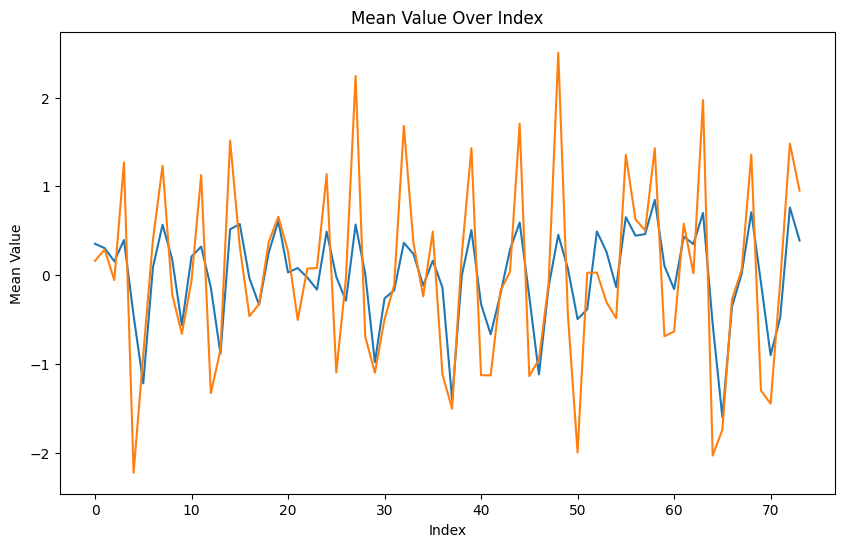

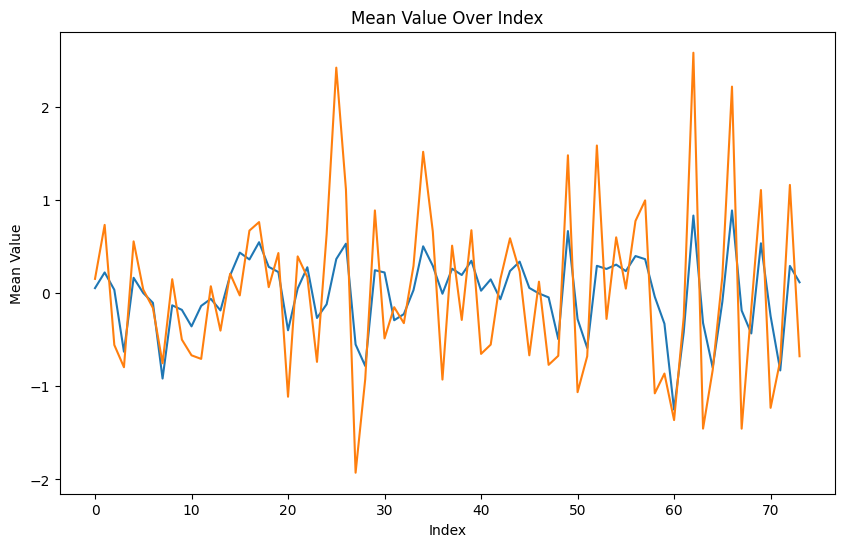

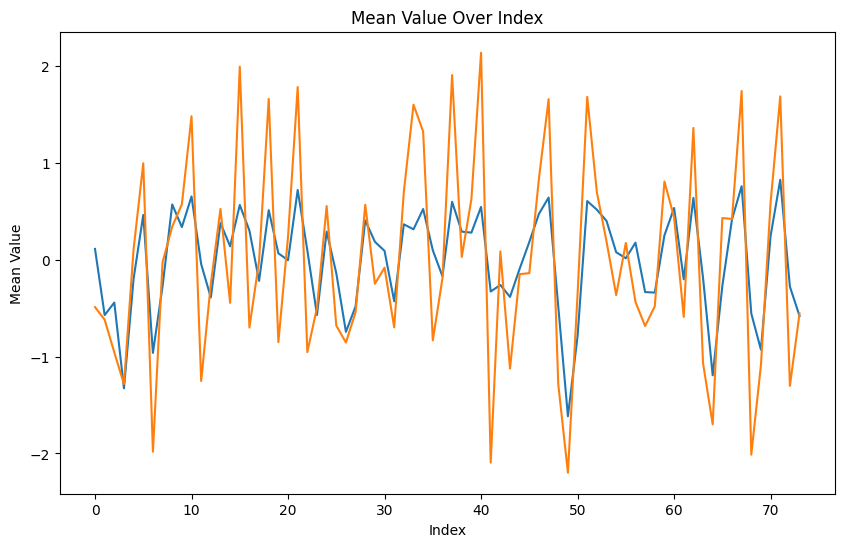

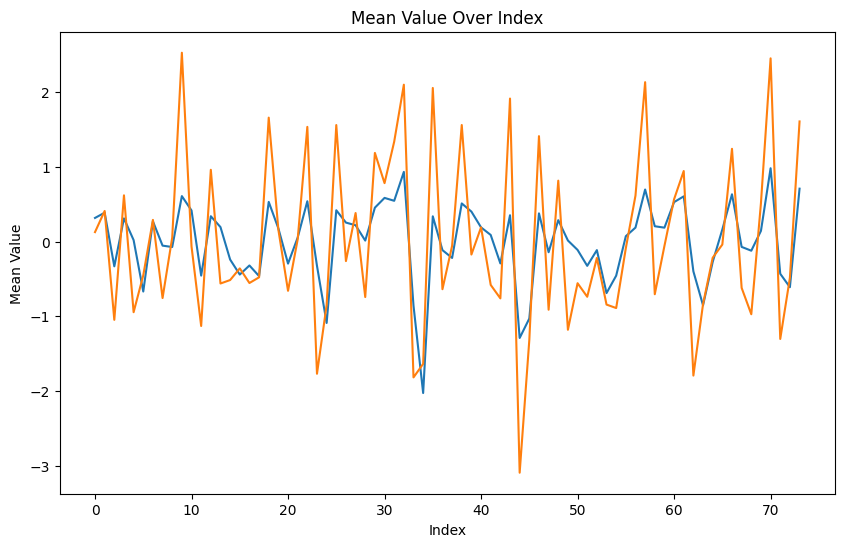

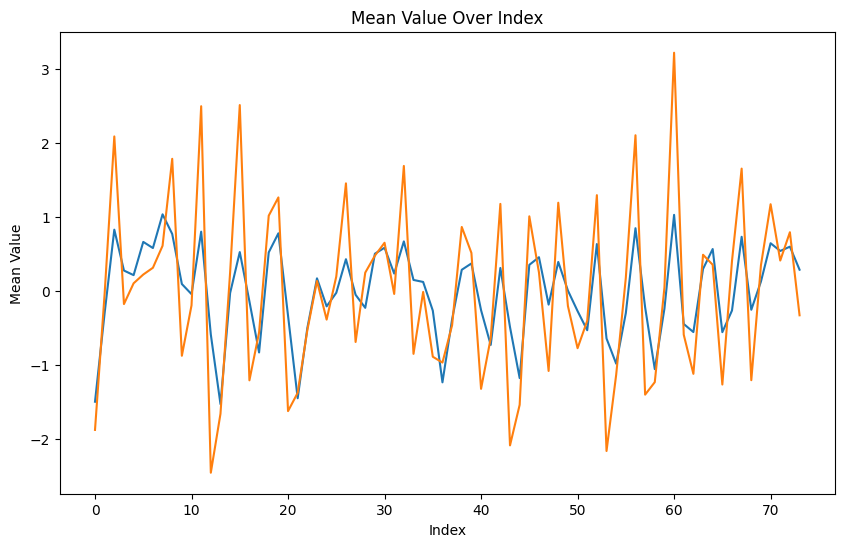

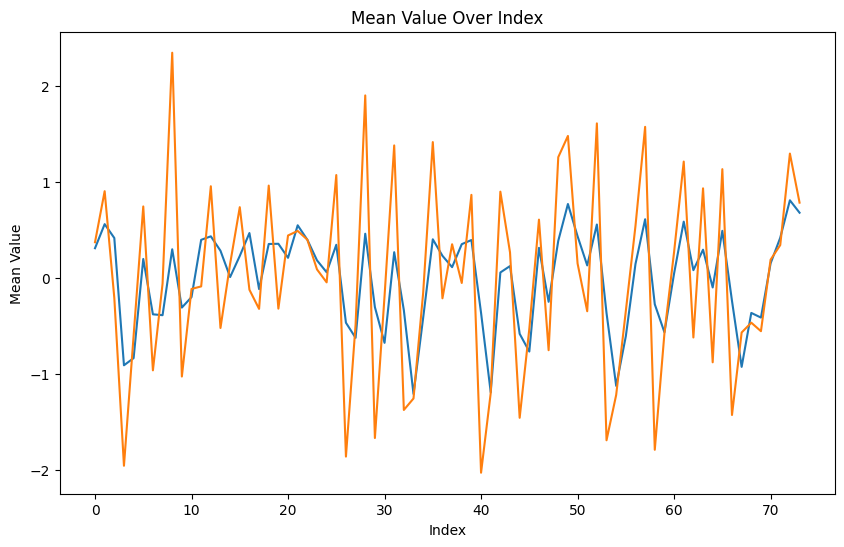

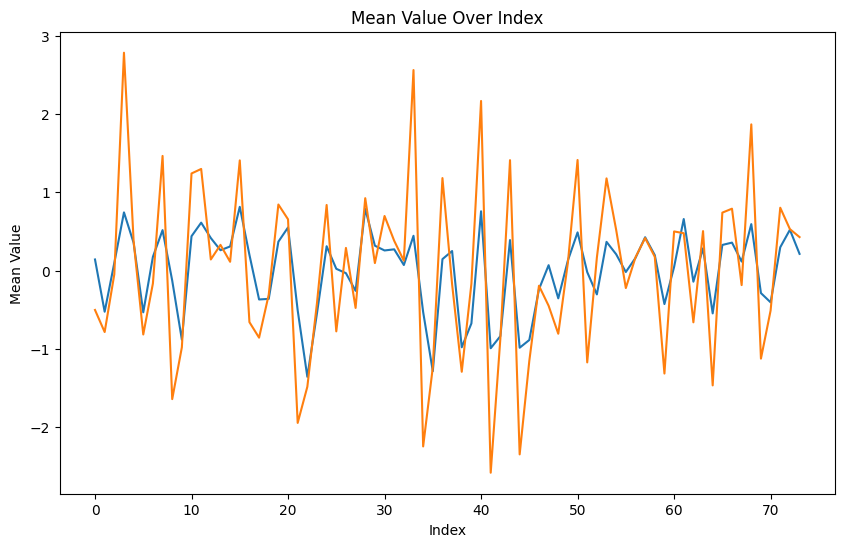

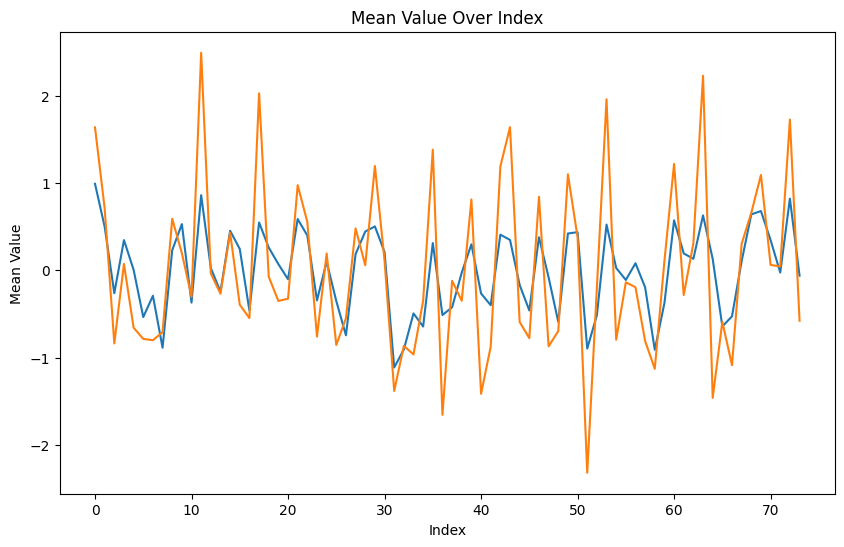

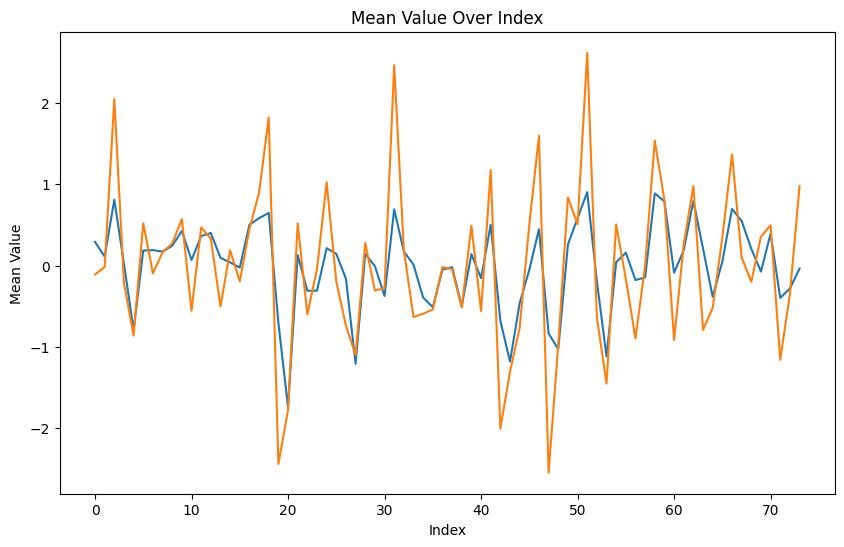

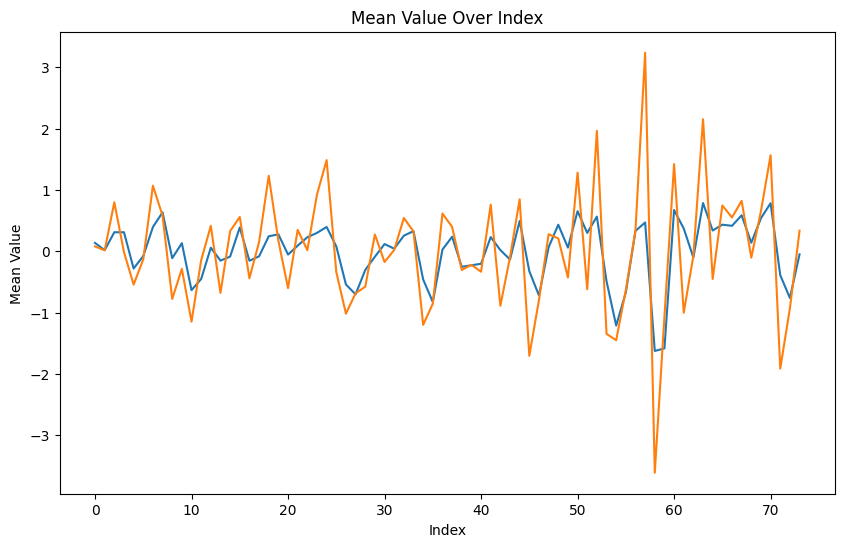

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
  # Compute mean along the second axis

for i in range(1,100):
  SST_sim = np.mean(X_reshaped[i, :, 86:96, 120:170], axis=(1,2))

  # Plotting with Seaborn
  plt.figure(figsize=(10, 6))
  sns.lineplot(x=range(len(SST_sim)), y=SST_sim)
  sns.lineplot(x=range(len(SST_sim)), y=nino_notrend[i*74:i*74+74]['Average_SST'])
  plt.xlabel("Index")
  plt.ylabel("Mean Value")
  plt.title("Mean Value Over Index")
  plt.show()

In [ ]:
#X_reshaped[0, 0, 80:100, 120:170].shape
# weights = np.cos(np.deg2rad(ds_nino34.lat))
# weights.name = 'weights'
# ds_weighted = ds_nino34['SST'].weighted(weights)
# mean_sst = ds_weighted.mean(dim=['lat', 'lon'])

'{:f}'.format(np.mean(X_reshaped[0, 1, 86:96, 120:170]))

In [ ]:
X = ds2['SST'].to_numpy()
np.max(X)

In [ ]:
np.max(X_reshaped[0,0])

In [ ]:
X_reshaped[0, :, 80:100, 120:170].shape

### Build CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, stride = (2,2), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 9, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 1 output value for Southern California

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 6 * 9)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()
model

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 5

### Train CNN

In [ ]:
%%time

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 16 == 15:    # print every 16 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.3f}')
            running_loss = 0.0

print('Finished Training')

### Tune CNN

### Test CNN

In [ ]:
predicted_data = []
actual_data = []

# Set the model to evaluation mode
model.eval()

# Iterate through the test dataloader
with torch.no_grad():
    for data in dataloader_test:
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        # Convert torch tensors to numpy arrays
        predicted_data.extend(outputs.numpy())
        actual_data.extend(labels.numpy())

In [ ]:
# Convert lists to numpy arrays
predicted_data = np.array(predicted_data)
actual_data = np.array(actual_data)

# Print the shapes of the predicted and actual data arrays
print("Predicted Data Shape:", predicted_data.shape)
print("Actual Data Shape:", actual_data.shape)

In [ ]:
pd.DataFrame(predicted_data).describe()

In [ ]:
pd.DataFrame(actual_data).describe()

In [ ]:
test_simulation_indices = np.linspace(start=0, stop=740, num=11)
test_simulation_indices

In [ ]:
for i in range(len(test_simulation_indices)-1):
  print(test_simulation_indices[i], test_simulation_indices[i+1])

  sim1_south_predicted = predicted_data[int(test_simulation_indices[i]):int(test_simulation_indices[i+1])]
  sim1_south_actual = actual_data[int(test_simulation_indices[i]):int(test_simulation_indices[i+1])]

  # Fit linear regression model
  regression_model = LinearRegression()
  regression_model.fit(sim1_south_actual, sim1_south_predicted)
  predicted_values = regression_model.predict(sim1_south_actual)
  r2_value = r2_score(sim1_south_predicted, predicted_values)

  # Plot scatter plot with line of best fit
  plt.figure(figsize=(8, 6))
  plt.scatter(sim1_south_actual, sim1_south_predicted, color='blue', alpha=0.6)
  plt.plot(sim1_south_actual, predicted_values, color='red', linewidth=2, label=f'Line of Best Fit (R^2={r2_value:.2f})')
  plt.title(f'Actual vs Predicted Values (test_sim{i+1}_south)')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.grid(True)
  plt.legend()
  plt.show()

## Potential Resources

https://www.nature.com/articles/s41598-020-57897-9

https://www.nature.com/articles/s41586-019-1559-7
- first architecture option

In [ ]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 200

In [ ]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        #X = X.to(device_cuda, non_blocking=True)
        #y = y.to(device_cuda, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            #X = X.to(device_cuda, non_blocking=True)
            #y = y.to(device_cuda, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [ ]:
# Train model and evaluate on validation set for each epoch
best_loss = np.inf
patience = 10
no_improvement_counter = 0

for t in range(epochs):

    if no_improvement_counter > patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        #best_model_weights = model.state_dict().copy() # save best model
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1

print("Done!")

In [ ]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)

    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)

    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)

    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)

    return r2



actual_values = np.array(y_test.squeeze(1))

# Instantiate model
model_best_weights = Net()
#model_best_weights = DenseNet(num_classes=1, growth_rate=32, block_config=(6, 12, 24, 16))

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

# Set the model to evaluation mode
model_best_weights.eval()
#model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1)).squeeze(1).detach().numpy()
#predicted_values = model(X_test.unsqueeze(1)).squeeze(1).detach().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

In [ ]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df

In [ ]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()